# TensorFlow/Keras Implementation of "A Neural Algorithm of Artistic Style"

## Pittsburgh Machine Learners - 2018-02-22

Code and content adapted from https://github.com/fastai/courses/blob/master/deeplearning2/neural-style.ipynb

### Install Prereqs

This notebook is written in Python3.

A few libraries are required before we get started. These are listed in `requirements.txt`:

In [1]:
!cat requirements.txt

keras
scipy
pillow
h5py
matplotlib
tensorflow
#tensorflow-gpu


If you have an NVIDIA GPU with CUDA/cuDNN installed then uncomment the `#tensorflow-gpu` line and comment `tensorflow`. Do the reverse to use the CPU-only version of TF.

To install the libs in one line (this may need to be run from the shell if using a virtualenv):

In [ ]:
!pip install -r requirements.txt

## Setup

In [3]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import scipy.misc
from PIL import Image
from keras.models import Model
import keras.backend as K
from vgg16_avg import VGG16_Avg

Using TensorFlow backend.


Create a `results` folder to store our stylized output. Change `OUT_PATH` to a different root dir if needed.

In [4]:
OUT_PATH = './'

In [5]:
os.makedirs(OUT_PATH + 'results', exist_ok=True)

Our first step is to load a content image and resize it to small enough dimensions that it will fit in GPU memory:

In [ ]:
content_img = Image.open('./input/content/kenji-portrait.jpg')
content_img = scipy.misc.imresize(content_img, 0.25);

(504, 378, 3)


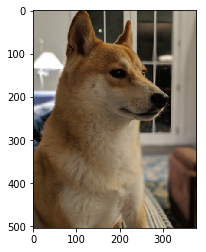

In [7]:
print(content_img.shape)
plt.imshow(content_img)

We'll be using this image with the VGG16 model pre-trained for ImageNet classification. Therefore, we need to subtract the mean of each channel of the ImageNet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using broadcasting.

In [8]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]  # RGB->BGR and subtract mean pixels for each channel

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [9]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [10]:
content_img_preproc = preproc(np.expand_dims(np.array(content_img), 0)) # Preprocess image and add batch dimension
shp = content_img_preproc.shape

### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations at some chosen layer. In earlier layers, content loss is very similar to per-pixel loss, but in later layers it is capturing higher-order structure in the image rather than the specific details.

To do this, we first pass an image through VGG. We then pass a "noise image" (i.e. random pixel values) through the same net. At some layer, we compare the outputs from it for both images. We then use a mean-squared error (MSE) to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, **we update the pixels of the noisy image**. In other words, our goal is to **alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.**

We're going to be working with keras.backend, which is an abstraction layer for TensorFlow that can also work with theano and CNTK.

The image classification CNN we'll use is VGG16, but with average pooling instead of max pooling. This is recommended by the original paper in order to improve gradient flow and gives slightly more appealing results.

Note the param **`include_top=False`** that excludes the unneeded fully-connected layers at the top of the model (since we're not using this for classification and only need intermediate conv activations).

In [11]:
from vgg16_avg import VGG16_Avg

model = VGG16_Avg(include_top=False)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

Here we're grabbing the activations from near the end of the convolutional model at layer `block5_conv1`.

In [12]:
layer = model.get_layer('block5_conv1').output
layer

<tf.Tensor 'block5_conv1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>

And let's calculate the target activations for this layer using a Keras functional Model:

In [13]:
layer_model = Model(model.input, layer) # Create a model that will output layer activations given an input img

targ = layer_model.predict(content_img_preproc) # Forward content_img through the model and store the output activations
targ.shape

(1, 31, 23, 512)

`targ` will be used for the content reconstruction loss.

Next, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scipy's optimizers require.

In [14]:
class Evaluator(object):
    def __init__(self, f, shp): 
        self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)]) # self.f should return the loss value and gradients
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64) # Helper to flatten calculated grads

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

Note that `layer` is the output tensor for the `block5_conv1` layer that will contain the output activations at each iteration. `targ` is static target that we want `layer` to be close to.

In [15]:
loss = K.sum((layer - targ)**2)

We also need to define an op that calculates the gradients of the loss with respect to the input image. These will be used by the optimizer to iteratively update the input image pixels to minimize the loss.

In [16]:
grads = K.gradients(loss, model.input)

Define a Keras function that expects as input an image tensor and outputs the loss & gradients. This is passed to Evaluator to create an object for the optimizer to query. 

In [17]:
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search approach called [L-BFGS](https://en.wikipedia.org/wiki/LBFGS), which we can implement with scipy `fmin_l_bfgs_b`. This method will iteratively update a given noise image `x` using the Evaluator object and loss/gradient function we defined above.

In [18]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        scipy.misc.imsave(OUT_PATH + 'results/res_at_iteration_{}.png'.format(i), deproc(x.copy(), shp)[0])
    return x

We're ready to start the optimization process. The first step is to generate a random noise image that the optimizer will iteratively update guided by the loss.

In [19]:
def rand_img(shape):
    return np.random.uniform(0, 1, shape)

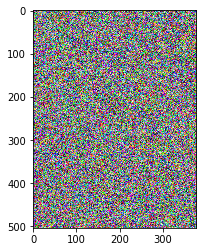

In [20]:
x = rand_img(shp)

plt.imshow(x[0]);

Now we'll run the optimizer 10 times to update the noise image pixels to more closely match the content image, as measured by activations at VGG layer `block5_conv1`.

In [21]:
iterations = 10

In [ ]:
x = solve_image(evaluator, iterations, x)

Using the activations at conv 1 of last block (5) is fairly amorphous, but the overall structure of the original image recognizable. Notice that the things it has reconstructed particularly well are those things that we expect VGG trained on ImageNet to be good at recognizing, such as dog ears and nose.

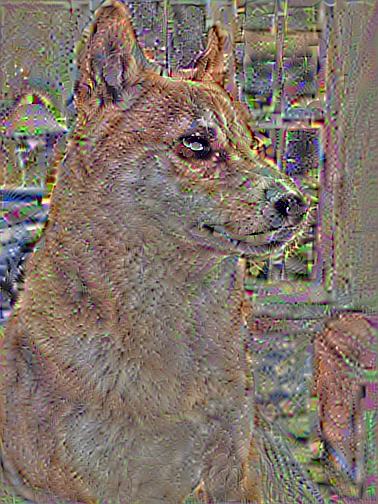

In [23]:
Image.open(OUT_PATH + 'results/res_at_iteration_9.png')

If instead we optimized by calculating loss from the output of an earlier layer like conv 1 of 3rd block, our optimized image would look much closer to the original. This makes sense because with fewer transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

To get a sense of how the noise image is transformed at each iteration of the optimization process, let's create an animation using the intermediate images:

In [24]:
from IPython.display import HTML
from matplotlib import animation, rc

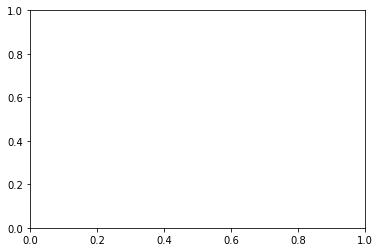

In [25]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(OUT_PATH + 'results/res_at_iteration_{}.png'.format(i)))

In [26]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### Recreate style

Now that we've learned how to recreate an input image using MSE at a given layer, we'll move onto recreating *style* with a gram matrix-based loss.

Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

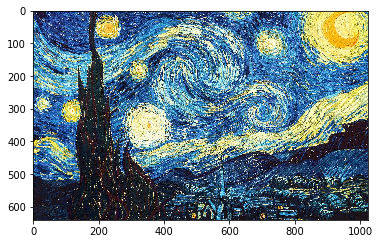

In [27]:
style_img = Image.open('./input/style/023.jpg')
plt.imshow(style_img)

In [ ]:
style_img = scipy.misc.imresize(style_img, 0.5) 
print(style_img.shape)

We're going to repeat the same approach as before, but with some differences.

In [29]:
style_img_preproc = preproc(np.expand_dims(style_img, 0))
shp = style_img_preproc.shape

In [30]:
# Gather the output tensors for all layers
outputs = {l.name: l.output for l in model.layers}

This time the loss will be based on activations at multiple layers. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

For this we'll use the outputs of layers `block1_conv1` and `block2_conv1`

In [31]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]
layers

[<tf.Tensor 'block1_conv1/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>]

In [32]:
# Create model that outputs activations of multiple layers in one call
layers_model = Model(model.input, layers)  

# Forward style img through model to get static targets for loss
targs = [o for o in layers_model.predict(style_img_preproc)]

The key difference is our choice of loss function. Whereas before we were calculating MSE of the raw convolutional outputs, here we transform them into the "gramian matrix" of their channels (that is, the product of a matrix and its transpose) before taking their MSE. It's unclear why this helps us achieve our goal, but it works. 

One thought is that the gramian shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [33]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # Calculate the size of the tensor = H*W*C
    size = tf.cast(tf.size(x), tf.float32)
    # The dot product of this with its transpose shows the correlation between each pair of channels
    return K.dot(features, K.transpose(features)) / size

Style loss is very similar to the content loss above, but it is the MSE between gram matrices instead of the raw activations.

In [34]:
def style_loss(x, targ):
    return K.mean((gram_matrix(x) - gram_matrix(targ))**2)

In [35]:
# Calculate style loss for individual layers and sum to get total loss
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)

As before, define a Keras function that expects as input an image tensor and outputs the style loss & gradients. Instantiate an Evaluator with this function.

In [36]:
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

And then solve.

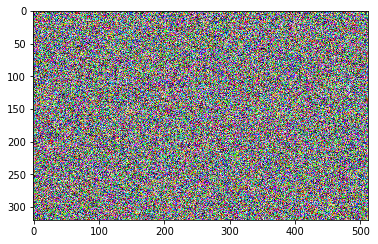

In [37]:
x = rand_img(shp)
plt.imshow(x[0]);

In [ ]:
iterations = 10

x = solve_image(evaluator, iterations, x)

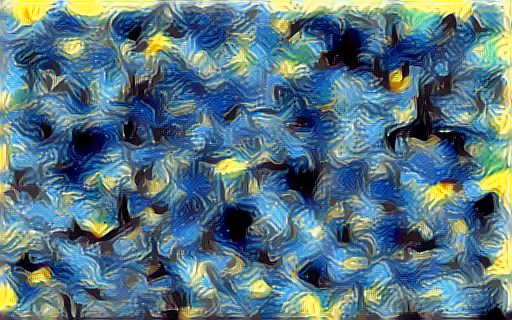

In [39]:
Image.open('results/res_at_iteration_9.png')

### Style transfer

We now know how to reconstruct an image from a conv layer, as well as how to construct an image that captures the style of an original image. Style Transfer just combines these two approaches by weighting and adding the two loss functions.

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab?

As noted earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect. Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [40]:
# Get style outputs for conv 2 of blocks 1..5
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
# Get content output for single layer
content_layer = outputs['block4_conv2']

In [41]:
style_model = Model(model.input, style_layers)
style_targs = [o for o in style_model.predict(style_img_preproc)] # targets for style loss

In [42]:
content_model = Model(model.input, content_layer)
content_targ = content_model.predict(content_img_preproc)         # target for content loss

In [43]:
shp = content_img_preproc.shape  # Output image will have same shape as content image

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixels we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1. If we decrease that weight, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small then the image will not have enough style.

We can also tune the contribution of each style layer to the total style loss by specifying a `style_weights` array. By default we're weighting the layers equally.

In [44]:
# style_wgts = [0.05,0.1,0.1,0.35,0.4]
style_weights = [1 / len(style_layers)]*len(style_layers)  # Uniform weight of 0.2
style_weights

[0.2, 0.2, 0.2, 0.2, 0.2]

In [45]:
alpha = 1.  # Weight for content loss
beta = 2.   # Weight for (total) style loss

In [46]:
# Content loss is MSE between content layer output and precalculated target from content img
loss_content = K.mean((content_layer - content_targ)**2)

# Style loss is sum of MSE between gram matrices for all style layers, weighted by style_weights
loss_style = sum(style_loss(l1[0], l2[0]) * w
           for l1, l2, w in zip(style_layers, style_targs, style_weights))

# Add losses together to get total loss, weighted by alpha/beta
loss_total = alpha * loss_content + beta * loss_style

The gradient function now calculates the total loss w.r.t. the input image.

In [47]:
grads = K.gradients(loss_total, model.input)
transfer_fn = K.function([model.input], [loss_total]+grads)
evaluator = Evaluator(transfer_fn, shp)

We're ready to solve for the combined content/style loss.

In [48]:
x = rand_img(shp)

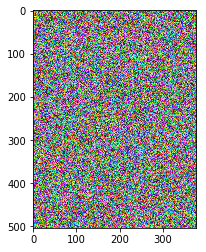

In [49]:
plt.imshow(x[0])

In [ ]:
iterations = 10

x = solve_image(evaluator, iterations, x)

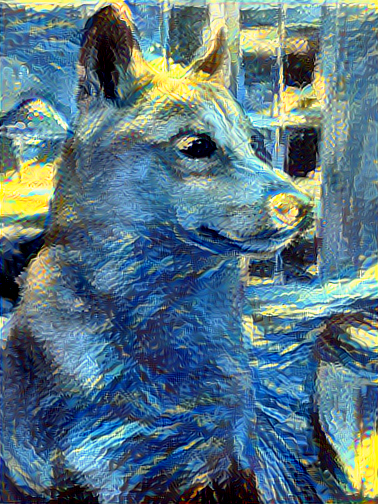

In [51]:
Image.open(OUT_PATH + 'results/res_at_iteration_{}.png'.format(iterations-1))

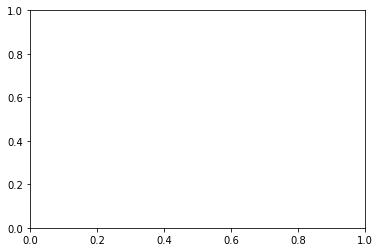

In [52]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(OUT_PATH + 'results/res_at_iteration_{}.png'.format(i)))

In [53]:
anim = animation.FuncAnimation(fig, animate, frames=iterations, interval=200)
HTML(anim.to_html5_video())